In [1]:
import numpy as np
import scipy.linalg as scila
import TransportMaps.Distributions as DIST
import matplotlib.pyplot as plt
%matplotlib inline

# Distributions

In this section we will discuss the declaration of simple distributions, which then can be used to define more complex distributions arising in Bayesian inference.

A distribution $\nu_\pi$ is characterized by two components (methods):

* a density function $\pi:\mathbb{R}^d\rightarrow\mathbb{R}$ (and possibly its gradient $\nabla\pi$ and Hessian $\nabla^2\pi$),
* a number of different quadratures $\mathcal{Q}_\ell$, with different convergence properties as $\ell\rightarrow\infty$.

Let us remind that the quadrature $\mathcal{Q}_\ell$ is characterized by a set of nodes and weights $\{{\bf x}_i,w_i\}_{i=1}^{n_\ell}$ (usually with $n_0 < n_1 < \ldots$) and the operator $\mathcal{Q}_\ell(f) = \sum_{i=1}^{n_\ell} f({\bf x}_i) w_i$, such that

$$ \mathcal{Q}_\ell(f) \rightarrow \int f({\bf x}) \nu_\pi(d{\bf x}) \quad \text{as} \quad \ell\rightarrow\infty\;. $$

This definition of quadrature encompasses also randomized quadratures, such as Monte-Carlo, importance sampling, latin hyper-cube, Markov chain Monte-Carlo, etc.
The exclusive availability of the density $\pi$ or a quadrature $\mathcal{Q}_\ell$ will define either **inference** problems (the quest for qaudratures) or **density estimation** problems (the quest for densities) respectively.

A number of classic one-dimensional and multi-dimensional distributions are already provided in the module [TransportMaps.Distributions](api-TransportMaps-Distributions.html). Without loss of generality and only for pedagogical purposes, we will define only Gaussian distributions in the following. Gaussian distributions are ubiquitous in statistical models, therefore they are are already pre-defined in the package (see [TransportMaps.Distributions.GaussianDistribution](api-TransportMaps-Distributions.html#TransportMaps.Distributions.GaussianDistribution)).

## 1D distributions

We start with the definition of a one dimensional Gaussian distribution, $\nu_\pi = \mathcal{N}(\mu, \sigma^2)$. Let us start with defining the distribution in terms of its density $\pi$ or, better, its log-density $\log\pi$, which is better behaved in many statistical settings. For a Gaussian distribution:

$$ \pi(x) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left( - \frac{(x-\mu)^2}{2\sigma^2} \right) $$
$$ \log\pi(x) = - \frac{(x-\mu)^2}{2\sigma^2} - \frac{1}{2} \log(2\pi\sigma^2) $$
$$ \nabla\log\pi(x) = -\frac{(x-\mu)}{\sigma^2} $$
$$ \nabla^2\log\pi(x) = -\frac{1}{\sigma^2} $$

### Declaration of the density
Let us declare this distribution through its **density** (note that we need only the log-density) ...

In [2]:
class Gaussian1D(DIST.Distribution):
    def __init__(self, mu, sigma2):
        self.mu = mu
        self.sigma = np.sqrt( sigma2 )
        super(Gaussian1D, self).__init__(1) # This sets self.dim=1
    def log_pdf(self, x, *args, **kwargs):
        # x.shape is (m,1)
        # Returns array of (m,) elements
        out = -(x-self.mu)**2/(2*self.sigma**2) - .5 * np.log(2*np.pi*self.sigma**2)
        return out[:,0]
    def grad_x_log_pdf(self, x, *args, **kwargs):
        # x.shape is (m,1)
        # Returns array of (m,1) elements
        out = -(x-self.mu)/self.sigma**2
        return out
    def hess_x_log_pdf(self, x, *args, **kwargs):
        # x.shape is (m,1)
        # Returns array of (m,1,1) elements
        out = - np.ones(x.shape[0]) / self.sigma**2
        return out[:,np.newaxis,np.newaxis]

... let's create an instance of this distribution ...

In [3]:
mu = 2.
sigma2 = 0.5
nupi = Gaussian1D(mu, sigma2)

... let us plot the density ...

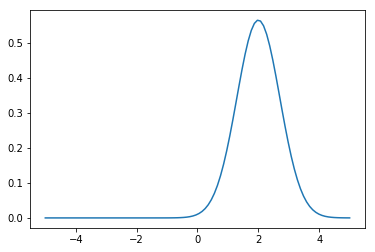

In [4]:
x = np.linspace(-5,5,100)[:,np.newaxis]  # array (m,1)
plt.figure();
plt.plot(x, nupi.pdf(x));

### Declaration of quadrature rules
Let us now declare the distribution through one **quadrature rule**. In this case we will define a Monte-Carlo quadrature rule. A sample from $\nu_\pi$ can be easily obtained from a sample $z \stackrel{\rm i.i.d}{\sim} \mathcal{N}(0,1)$, through the following transformation:

$$ x = \mu + \sigma z \;. $$

Then, we can use (in this case) the pseudo-random number generator of [numpy](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randn.html#numpy.random.randn).

In [5]:
class Gaussian1D_MC(DIST.Distribution):
    def __init__(self, mu, sigma2):
        self.mu = mu
        self.sigma = np.sqrt( sigma2 )
        super(Gaussian1D_MC, self).__init__(1) # This sets self.dim=1
    def quadrature(self, qtype, qnum, *args, **kwargs):
        if qtype == 0: # The type 0 is reserved for MC sampling
            z = np.random.randn(qnum)
            x = self.mu + self.sigma * z
        return x

In the class definition above we declared a Monte-Carlo quadrature (which correspond to ``qtype=0``). Other types of quadratures could be defined with different ``qtype`` numbers. Note however that ``qtype==0`` is *reserved* to Monte-Carlo quadratures, due to the fact that the method ``Distribution.rvs(n)`` (sharing the name with its counterpart in [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.rvs.html)) will call ``Distribution.quadrature(0,n)``.

Let us now construct an instance of this distribution...

In [6]:
nupi = Gaussian1D_MC(mu, sigma2)

... and plot some Monte-Carlo samples ...

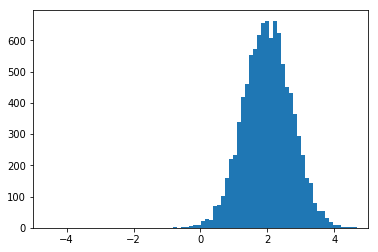

In [7]:
smp = nupi.quadrature(0, 10000) # Equivalent to: nupi.rvs(10000)
plt.figure(); plt.xlim(-5,5)
plt.hist(smp,bins=50);

In density estimation problems a sample from an unknown distribution is available, then such a distribution can be defined as shown above.

## nD distributions

Let us now devote our attention to the two dimensional Gaussian distribution $\nu_\pi = \mathcal{N}({\bf \mu},\Sigma)$, where $\Sigma$ is symmetric positive definite. Let again start with the definition of the log-denisty and its derivatives:

$$ \log\pi(x) = - \frac{1}{2} (x-\mu)^\top\Sigma^{-1}(x-\mu) - \frac{1}{2} \log(2\pi) - \frac{1}{2} \log\left\vert\Sigma\right\vert $$
$$ \nabla\log\pi(x) = -\Sigma^{-1}(x-\mu) $$
$$ \nabla^2\log\pi(x) = - \Sigma^{-1} $$

### Declaration of the density
Without the pretence of optimality in the implementation, we consider the Cholesky factorization $LL^\top=\Sigma$, and encode this log-density as follows:

In [8]:
class Gaussian2D(DIST.Distribution):
    def __init__(self, mu, sigma):
        super(Gaussian2D, self).__init__(2) # This sets self.dim=2
        self.mu = mu
        self.sigma = sigma
        chol = scila.cho_factor(self.sigma, True) # True: lower triangular
        self.det_sigma = np.prod(np.diag(chol[0]))**2.
        self.log_det_sigma = 2. * np.sum( np.log( np.diag(chol[0]) ) )
        self.inv_sigma = scila.cho_solve(chol, np.eye(self.dim))
    def log_pdf(self, x, *args, **kwargs):
        # x.shape is (m,2)
        # Returns array of (m,) elements
        b = x - self.mu
        sol = np.dot( self.inv_sigma, b.T ).T
        out = - .5 * np.einsum('...i,...i->...', b, sol) \
              - self.dim * .5 * np.log(2.*np.pi) \
              - .5 * self.log_det_sigma
        return out.flatten()
    def grad_x_log_pdf(self, x, *args, **kwargs):
        # x.shape is (m,2)
        # Returns array of (m,2) elements
        b = x - self.mu
        return - np.dot( self.inv_sigma, b.T ).T
    def hess_x_log_pdf(self, x, *args, **kwargs):
        # x.shape is (m,2)
        # Returns array of (m,2,2) elements
        return - np.ones(x.shape[0])[:,nax,nax] * self.inv_sigma[nax,:,:]

Let us create an instance of this distribution ...

In [9]:
mu = np.array([2., 1.])
sigma = np.array([[2., 1.],
                  [1., 3.]])
nupi = Gaussian2D(mu, sigma)

... and let's plot the density ...

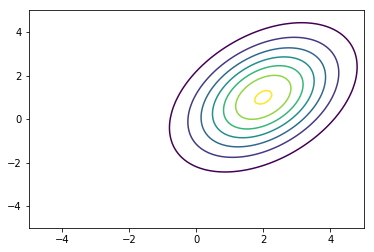

In [10]:
x = np.linspace(-5,5,100)
X,Y = np.meshgrid(x,x)
xx = np.vstack((X.flatten(),Y.flatten())).T # xx.shape is (100^2,2)
pdf = nupi.pdf(xx).reshape(X.shape)
plt.figure()
plt.contour(X,Y,pdf)

### Declaration of quadrature rules
Let us again declare the distribution, by defining only on quadrature (Monte-Carlo) rule. Given a sample ${\bf z} \stackrel{\rm i.i.d}{\sim}\mathcal{N}(0,{\bf I})$, a sample from $\nu_\pi$ can be obtained using the following transformation:

$$ {\bf x} = {\bf \mu} + L {\bf z} \;. $$

Again, we use the pseudo-random number generator from [numpy](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randn.html#numpy.random.randn) to generate ${\bf z}$.

In [11]:
class Gaussian2D_MC(DIST.Distribution):
    def __init__(self, mu, sigma):
        super(Gaussian2D_MC, self).__init__(2) # This sets self.dim=2
        self.mu = mu
        self.sigma = sigma
        chol = scila.cho_factor(self.sigma, True) # True: lower triangular
        self.sampling_mat = np.tril(chol[0])
    def quadrature(self, qtype, qnum, *args, **kwargs):
        if qtype == 0: # The type 0 is reserved for MC sampling
            z = np.random.randn(self.dim * qnum).reshape((qnum,self.dim))
            x = self.mu + np.dot( self.sigma, z.T ).T
        return x

Let us construct an instance of this distribution ...

In [12]:
nupi = Gaussian2D_MC(mu, sigma)

... and plot a Monte-Carlo sample ...

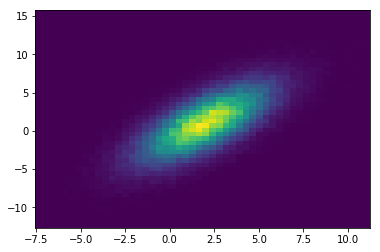

In [13]:
smp = nupi.quadrature(0, 100000) # Equivalent to: nupi.rvs(10000)
plt.figure();
plt.hist2d(smp[:,0],smp[:,1], bins=50);

## Conditional distributions

Conditional distributions represent an important building block for hierarchical and sequential statistical models. While the formal definition of conditional distributions is rather technical, here we will just use their *intuitive* definition. The symbol $\nu_\pi({\bf x}\vert{\bf y})$ is the law of the random variable ${\bf X}$ given the value ${\bf Y}={\bf y}$ of the random variable ${\bf Y}$ (we will write ${\bf X}\vert{\bf Y}={\bf y}$). Correspondigly the symbol $\pi({\bf x}\vert{\bf y})$ is the density of $\nu_\pi$.

Let us then define the law of $\left(X\vert Y=y\right) \sim \nu_\pi = \mathcal{N}(y^2, 1)$. This can be done extending the class [ConditionalDistribution](api-TransportMaps-Distributions.html#TransportMaps.Distributions.ConditionalDistribution).

In [14]:
class SquaredConditionallyGaussian(DIST.ConditionalDistribution):
    def __init__(self, sigma2):
        # This sets self.dim=1 and self.dim_y=1
        # where self.dim is the dimension of x and 
        # self.dim_y is the dimension of y
        super(SquaredConditionallyGaussian, 
              self).__init__(1, 1)
        self.sigma = np.sqrt(sigma2)
    def log_pdf(self, x, y, *args, **kwargs):
        # x.shape is (m,1)
        # y.shape is (m,1)
        # Returns array of (m,) elements
        out = -(x-y**2)**2/(2*self.sigma**2) - .5 * np.log(2*np.pi*self.sigma**2)
        return out[:,0]
    def grad_x_log_pdf(self, x, y, *args, **kwargs):
        # x.shape is (m,1)
        # y.shape is (m,1)
        # Returns array of (m,2) elements
        out = np.zeros((x.shape[0],2))
        out[:,0] = -(x-y**2)/self.sigma**2
        out[:,1] = -(x-y**2)*2*y/self.sigma**2
        return out
    def hess_x_log_pdf(self, x, y, *args, **kwargs):
        # x.shape is (m,1)
        # y.shape is (m,1)
        # Returns array of (m,2,2) elements
        out = np.zeros((x.shape[0],2,2))
        out[:,0,0] = - np.ones(x.shape[0]) / self.sigma**2
        out[:,1,1] = 2/self.sigma**2 * (2*y**2 - (x-y**2))
        out[:,0,1] = 2*y/self.sigma**2
        out[:,1,0] = out[:,0,1]
        return out

Let us instantiate this distribution and plot it as a function of $y$ ...

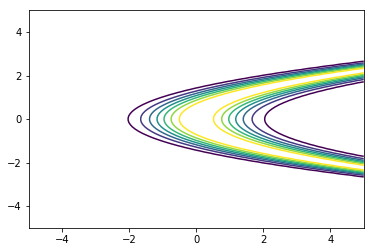

In [15]:
nupi = SquaredConditionallyGaussian(sigma2=1)
pdf = nupi.pdf(xx[:,[0]], xx[:,[1]]).reshape(X.shape)
plt.figure()
plt.contour(X,Y,pdf)

## Factorized distributions

Hierarchical and sequential statistical models rely on the factorization of some distributions. Here we look at the distribution of ${\bf X,Y} \sim \nu_\pi$ defined as follows:

$$ X \sim \nu_\rho = \mathcal{N}(\mu_x, \sigma^2_x) \;, $$
$$ Y\vert X \sim \nu_\mu = \mathcal{N}(x^2, \sigma^2_y) \;.$$

This means that the density of $\nu_\pi$ is defined as

$$ \pi(x,y) = \rho(x) \mu(y \vert x) \;. $$

We will define $\nu_\pi$ using the [FactorizedDistribution](api-TransportMaps-Distributions.html#TransportMaps.Distributions.FactorizedDistribution) class.

In [16]:
mux = 0.5
sigma2x = 0.8
nurho = Gaussian1D(mux, sigma2x)
sigma2y = 0.2
numu = SquaredConditionallyGaussian(sigma2y)
factors = [(nurho, [0], [] ),
           (numu,  [1], [0])]
nupi = DIST.FactorizedDistribution(factors)

Let us plot the density $\pi$ ...

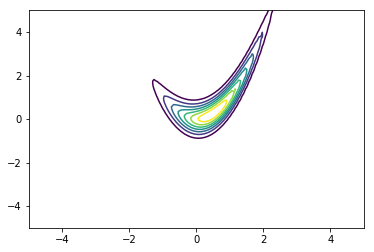

In [17]:
pdf = nupi.pdf(xx).reshape(X.shape)
plt.figure()
plt.contour(X,Y,pdf)